# PCA

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

m=80
X=np.zeros((m,3))
np.random.seed(42)
a=2*np.pi
angles=(np.random.rand(m)**3+0.5)*a




In [4]:
X[:,0],X[:,1]=np.cos(angles),np.sin(angles)*0.5
X+=0.28*np.random.randn(m,3)
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2] 

## Principal Components

In [6]:
X[:4,:]

array([[-0.45962568, -0.49378939, -0.08184797],
       [-0.29876844, -0.37051655, -0.25024707],
       [ 0.85588068,  0.74910295,  0.36477712],
       [ 0.53457432, -0.20161171,  0.0184662 ]])

In [7]:
X.mean(axis=0)

array([-0.15218894, -0.39184768,  0.13087493])

In [8]:
X_centered=X-X.mean(axis=0)
X_centered[:4]

array([[-0.30743674, -0.10194171, -0.2127229 ],
       [-0.1465795 ,  0.02133113, -0.381122  ],
       [ 1.00806962,  1.14095063,  0.23390219],
       [ 0.68676325,  0.19023597, -0.11240873]])

In [9]:
U,s,Vt=np.linalg.svd(X_centered)
Vt

array([[ 0.76244192,  0.61409942,  0.20387306],
       [-0.62281205,  0.78193493, -0.0261328 ],
       [-0.17546361, -0.10704985,  0.97864848]])

In [10]:
c1=Vt[0]
c2=Vt[1]

In [11]:
m,n=X.shape
Σ=np.zeros_like(X_centered)
Σ[:n,:n]=np.diag(s)
assert np.allclose(X_centered,U@Σ@Vt)

## Projecting Down to d Dimensions

In [13]:

W2=Vt[:2].T
X2D=X_centered@W2


In [14]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
X2D_pca=pca.fit_transform(X)

In [15]:
assert np.allclose(X2D,X2D_pca)

In [16]:
pca.components_

array([[ 0.76244192,  0.61409942,  0.20387306],
       [-0.62281205,  0.78193493, -0.0261328 ]])

In [17]:
pca.n_components_

2

## Explained Variance Ratio

In [19]:
pca.explained_variance_ratio_

array([0.73932035, 0.19019105])

In [20]:
1-pca.explained_variance_ratio_.sum()

0.07048860143242597

## Choosing the Right Number of Dimensions

In [22]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784',as_frame=False,parser="auto")
X_train,y_train=mnist.data[:60000],mnist.target[:60000]
X_test,y_test=mnist.data[60000:],mnist.target[60000:]

pca=PCA()
pca.fit(X_train)

PCA()

In [23]:
cumsum=np.cumsum(pca.explained_variance_ratio_)

In [24]:
d=np.argmax(cumsum>=0.95)+1

In [25]:
d

154

In [26]:
pca=PCA(n_components=0.95)
X_reduced=pca.fit_transform(X_train)

In [27]:
pca.n_components_

154

In [28]:
pca.explained_variance_ratio_.sum()

0.9501960192613034

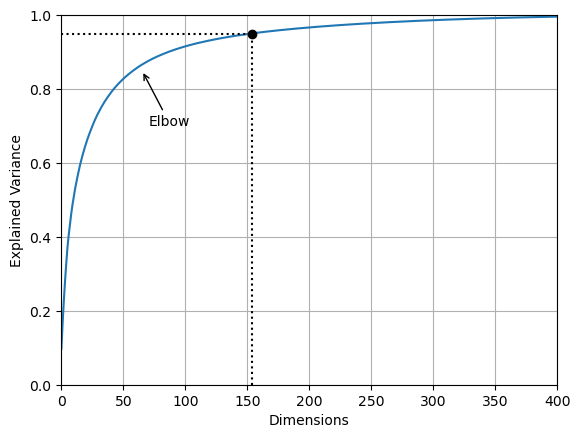

In [29]:
plt.plot(cumsum)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d,d],[0,0.95],"k:")
plt.plot([0,d],[0.95,0.95],"k:")
plt.plot(d,0.95,"ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf=make_pipeline(PCA(random_state=42),
                 RandomForestClassifier(random_state=42))
param_distrib={
    "pca__n_components":np.arange(10,80),
    "randomforestclassifier__n_estimators":np.arange(50,500)
}
rnd_search=RandomizedSearchCV(clf,param_distrib,cv=3,n_iter=10,random_state=42)
rnd_search.fit(X_train[:1000],y_train[:1000])


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [31]:
rnd_search.best_params_

{'randomforestclassifier__n_estimators': 475, 'pca__n_components': 57}

In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf=make_pipeline(PCA(random_state=42),SGDClassifier())
param_distrib={"pca__n_components":np.arange(10,80)}
grid_search=GridSearchCV(clf,param_distrib,cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [33]:
grid_search.best_params_

{'pca__n_components': 65}

## PCA for compression

In [35]:
pca=PCA(23)
X_reduced=pca.fit_transform(X_train,y_train)


In [36]:
X_recovered=pca.inverse_transform(X_reduced)

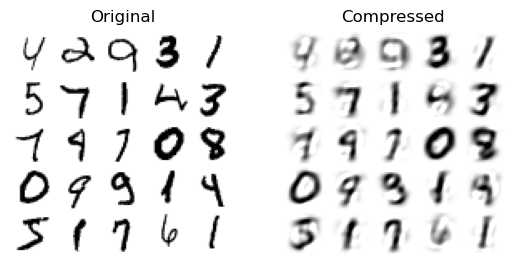

In [37]:
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

## Randomized PCA

In [39]:
rnd_pca=PCA(n_components=154,svd_solver="randomized",random_state=42)
X_reduced=rnd_pca.fit_transform(X_train)

## Incremental PCA

In [41]:
from sklearn.decomposition import IncrementalPCA

n_batches=100
inc_pca=IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train,n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced=inc_pca.transform(X_train)

In [42]:
filename="mnist_data.mmap"
X_mmap=np.memmap(filename,dtype="float32",mode="write",shape=X_train.shape)
X_mmap[:]=X_train
X_mmap.flush()

In [43]:
X_mmap=np.memmap(filename,dtype="float32",mode="readonly").reshape(-1,784)
batch_size=X_mmap.shape[0]//n_batches
inc_pca=IncrementalPCA(n_components=154,batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

In [44]:
a=inc_pca.transform(X_mmap)

In [45]:
a.shape

(60000, 154)

# Random Projection

In [47]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m,ε=6_000,0.1
d=johnson_lindenstrauss_min_dim(m,eps=ε)
d

7456

In [48]:
d=int(4*np.log(3)/(ε**2/2 -ε**3/3))
d

941

In [49]:
n=20000
np.random.seed(42)
P=np.random.randn(d,n)/np.sqrt(d)


In [50]:
X=np.random.randn(m,n)
X_reduced=X@P.T

In [51]:
X.shape

(6000, 20000)

In [52]:
P.shape

(941, 20000)

In [53]:
X_reduced.shape


(6000, 941)

In [54]:
from sklearn.random_projection import GaussianRandomProjection
grp=GaussianRandomProjection(eps=ε,random_state=42)
X_reduced=grp.fit_transform(X)

In [55]:
X_reduced.shape

(6000, 7456)

In [56]:
components_pinv=np.linalg.pinv(grp.components_)  #components_  -> The projection matrix  P used
X_recovered=X_reduced@components_pinv.T


In [57]:
X_recovered.shape

(6000, 20000)

In [58]:
# extra code – performance comparison between Gaussian and Sparse RP

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
2.44 s ± 73.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
1.65 s ± 8.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
13 s ± 780 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
2.5 s ± 238 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# LLE

In [60]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.datasets import make_swiss_roll

X_swiss,t= make_swiss_roll(n_samples=2000,noise=0.2,random_state=42)
lle=LocallyLinearEmbedding(n_components=2,n_neighbors=10,random_state=42)
X_reduced=lle.fit_transform(X_swiss)

In [61]:
from sklearn.manifold import MDS

mds=MDS(n_components=2,random_state=42)    # n_components=2 -> Reduce the data into 2 dimensions 
X_reduced_mds=mds.fit_transform(X_swiss)

In [62]:
from sklearn.manifold import Isomap

isomap=Isomap(n_components=2)
X_reduced_isomap=isomap.fit_transform(X_swiss)

In [63]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2,init="random",learning_rate="auto")
X_reduced_tsne=tsne.fit_transform(X_swiss)

# Exercise

# 9.

In [66]:
X_train,y_train=mnist.data[:60_000],mnist.target[:60_000]
X_test,y_test=mnist.data[60_000:],mnist.target[60_000:]

In [67]:
rnd_clf=RandomForestClassifier(n_estimators=100,random_state=42)

In [68]:
%time rnd_clf.fit(X_train,y_train)

CPU times: user 25.4 s, sys: 150 ms, total: 25.6 s
Wall time: 25.6 s


RandomForestClassifier(random_state=42)

In [69]:
from sklearn.metrics import accuracy_score

y_pred=rnd_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9691

In [70]:
pca=PCA(n_components=0.95)
X_train_reduce=pca.fit_transform(X_train)

In [71]:
rnd_clf_with_pca=RandomForestClassifier(n_estimators=100,random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduce,y_train)

CPU times: user 1min 14s, sys: 1.31 s, total: 1min 16s
Wall time: 1min 14s


RandomForestClassifier(random_state=42)

In [72]:
X_test_reduced=pca.transform(X_test)
y_pred=rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test,y_pred)

0.9487

In [73]:
sgd_clf=SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train,y_train)

CPU times: user 1min 48s, sys: 659 ms, total: 1min 48s
Wall time: 2min 31s


SGDClassifier(random_state=42)

In [74]:
y_pred=sgd_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.874

In [75]:
sgd_clf_with_pca=SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduce,y_train)

CPU times: user 19 s, sys: 1.51 s, total: 20.5 s
Wall time: 19 s


SGDClassifier(random_state=42)

In [76]:
y_pred=sgd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test,y_pred)

0.8959

# 10.

In [78]:
X_sample=mnist.data[:5000]
y_sample=mnist.target[:5000]

In [79]:
tsne=TSNE(n_components=2,init="random",learning_rate="auto",random_state=42)
%time X_reduced=tsne.fit_transform(X_sample) 

CPU times: user 36.5 s, sys: 1.27 s, total: 37.8 s
Wall time: 33.6 s


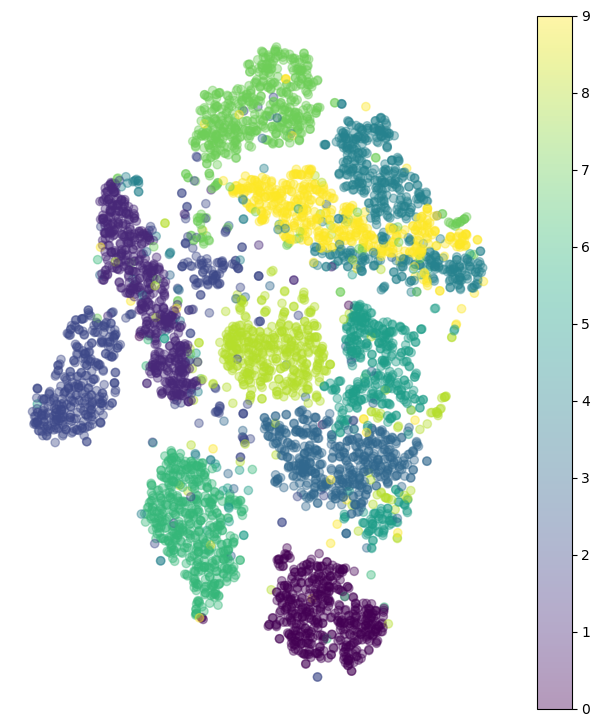

In [207]:
plt.figure(figsize=(8, 9))
plt.scatter(X_reduced[:,0],X_reduced[:,1],
            alpha=0.4,c=y_sample.astype(np.int8),cmap="viridis")
plt.axis("off")
plt.colorbar()
plt.show()

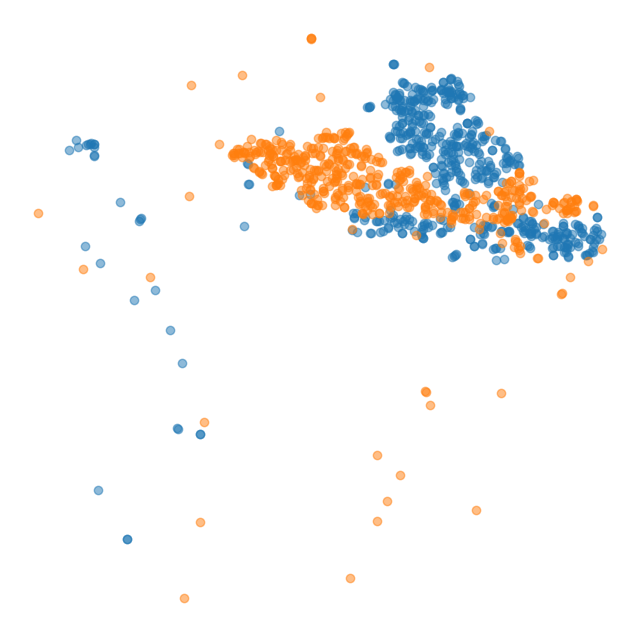

In [211]:
plt.figure(figsize=(8,8))
for digit in ('4','9'):
    plt.scatter(X_reduced[y_sample==digit,0],X_reduced[y_sample==digit,1],alpha=0.5)
plt.axis('off')
plt.show()

In [82]:
idx=(y_sample=='4')|(y_sample=='9')
X_subset=X_sample[idx]
y_subset=y_sample[idx]

tsne_subset=TSNE(n_components=2,init="random",learning_rate="auto",random_state=42)
%time X_subset_reduced=tsne_subset.fit_transform(X_subset)

CPU times: user 5.29 s, sys: 474 ms, total: 5.77 s
Wall time: 4.14 s


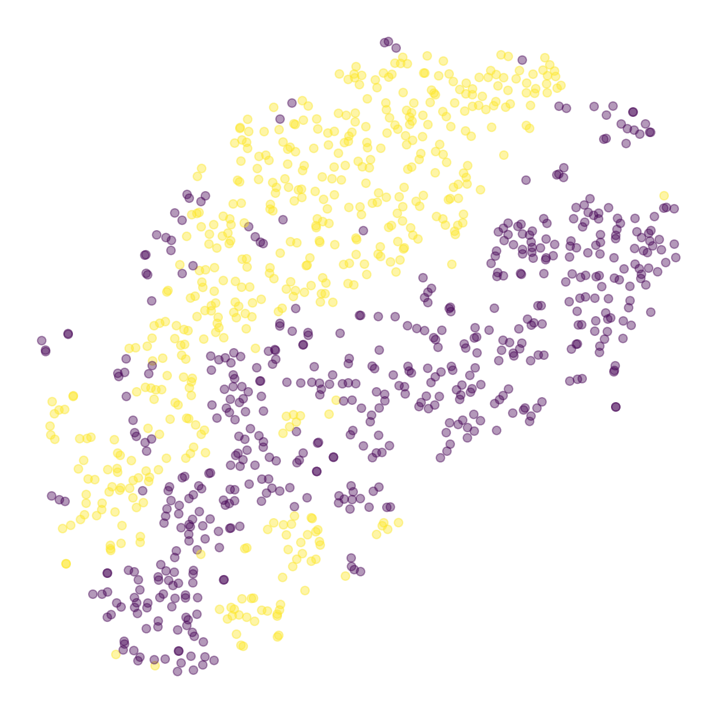

In [83]:
plt.figure(figsize=(9, 9))
plt.scatter(X_subset_reduced[:,0],X_subset_reduced[:,1],c=y_subset.astype(np.int8),cmap="viridis",alpha=0.4)
plt.axis("off")
plt.show()


In [84]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox,OffsetImage

def plot_digits(X,y,min_distance=0.04,images=None,figsize=(13,10)):
    if images is not None and figsize == (13, 10):
        figsize = (35, 25)
    
    X_normalized=MinMaxScaler().fit_transform(X)
    neighbours=np.array([[10,10]])

    plt.figure(figsize=figsize)
    cmap=plt.cm.viridis
    digits=np.unique(y)

    for digit in digits:
        plt.scatter(X_normalized[y==digit,0],X_normalized[y==digit,1],c=[cmap(float(digit)/9)],alpha=0.5)
        
    plt.axis("off")
    ax = plt.gca()  
    for index,image_coord in enumerate(X_normalized):
        closest_distance=np.linalg.norm(neighbours-image_coord,axis=1).min()
        if closest_distance > min_distance:
            neighbours=np.r_[neighbours,[image_coord]]
            if images is None:
                plt.text(image_coord[0],image_coord[1],str(int(y[index])),
                        color=cmap(float(y[index])/9),
                        fontdict={"weight":"bold","size":16})
            else:
                image=images[index].reshape(28,28)
                image_box=AnnotationBbox(OffsetImage(image,cmap="binary"),image_coord)
                ax.add_artist(image_box)
            
      
  
    

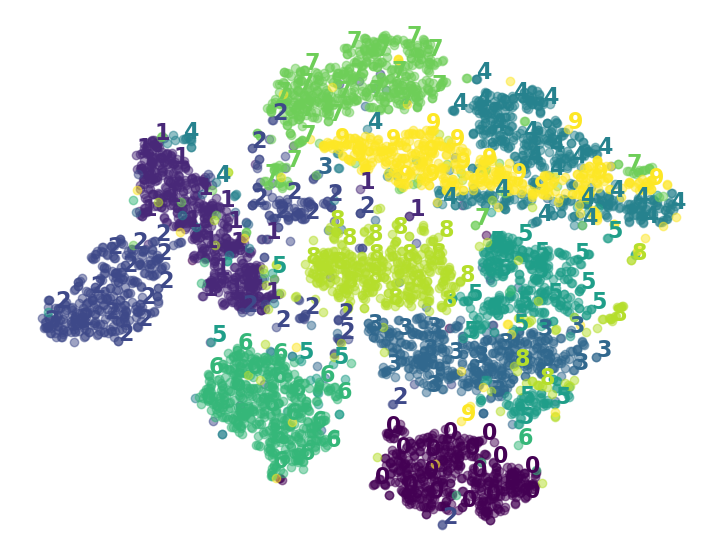

In [195]:
plot_digits(X_reduced,y_sample,figsize=(9,7))


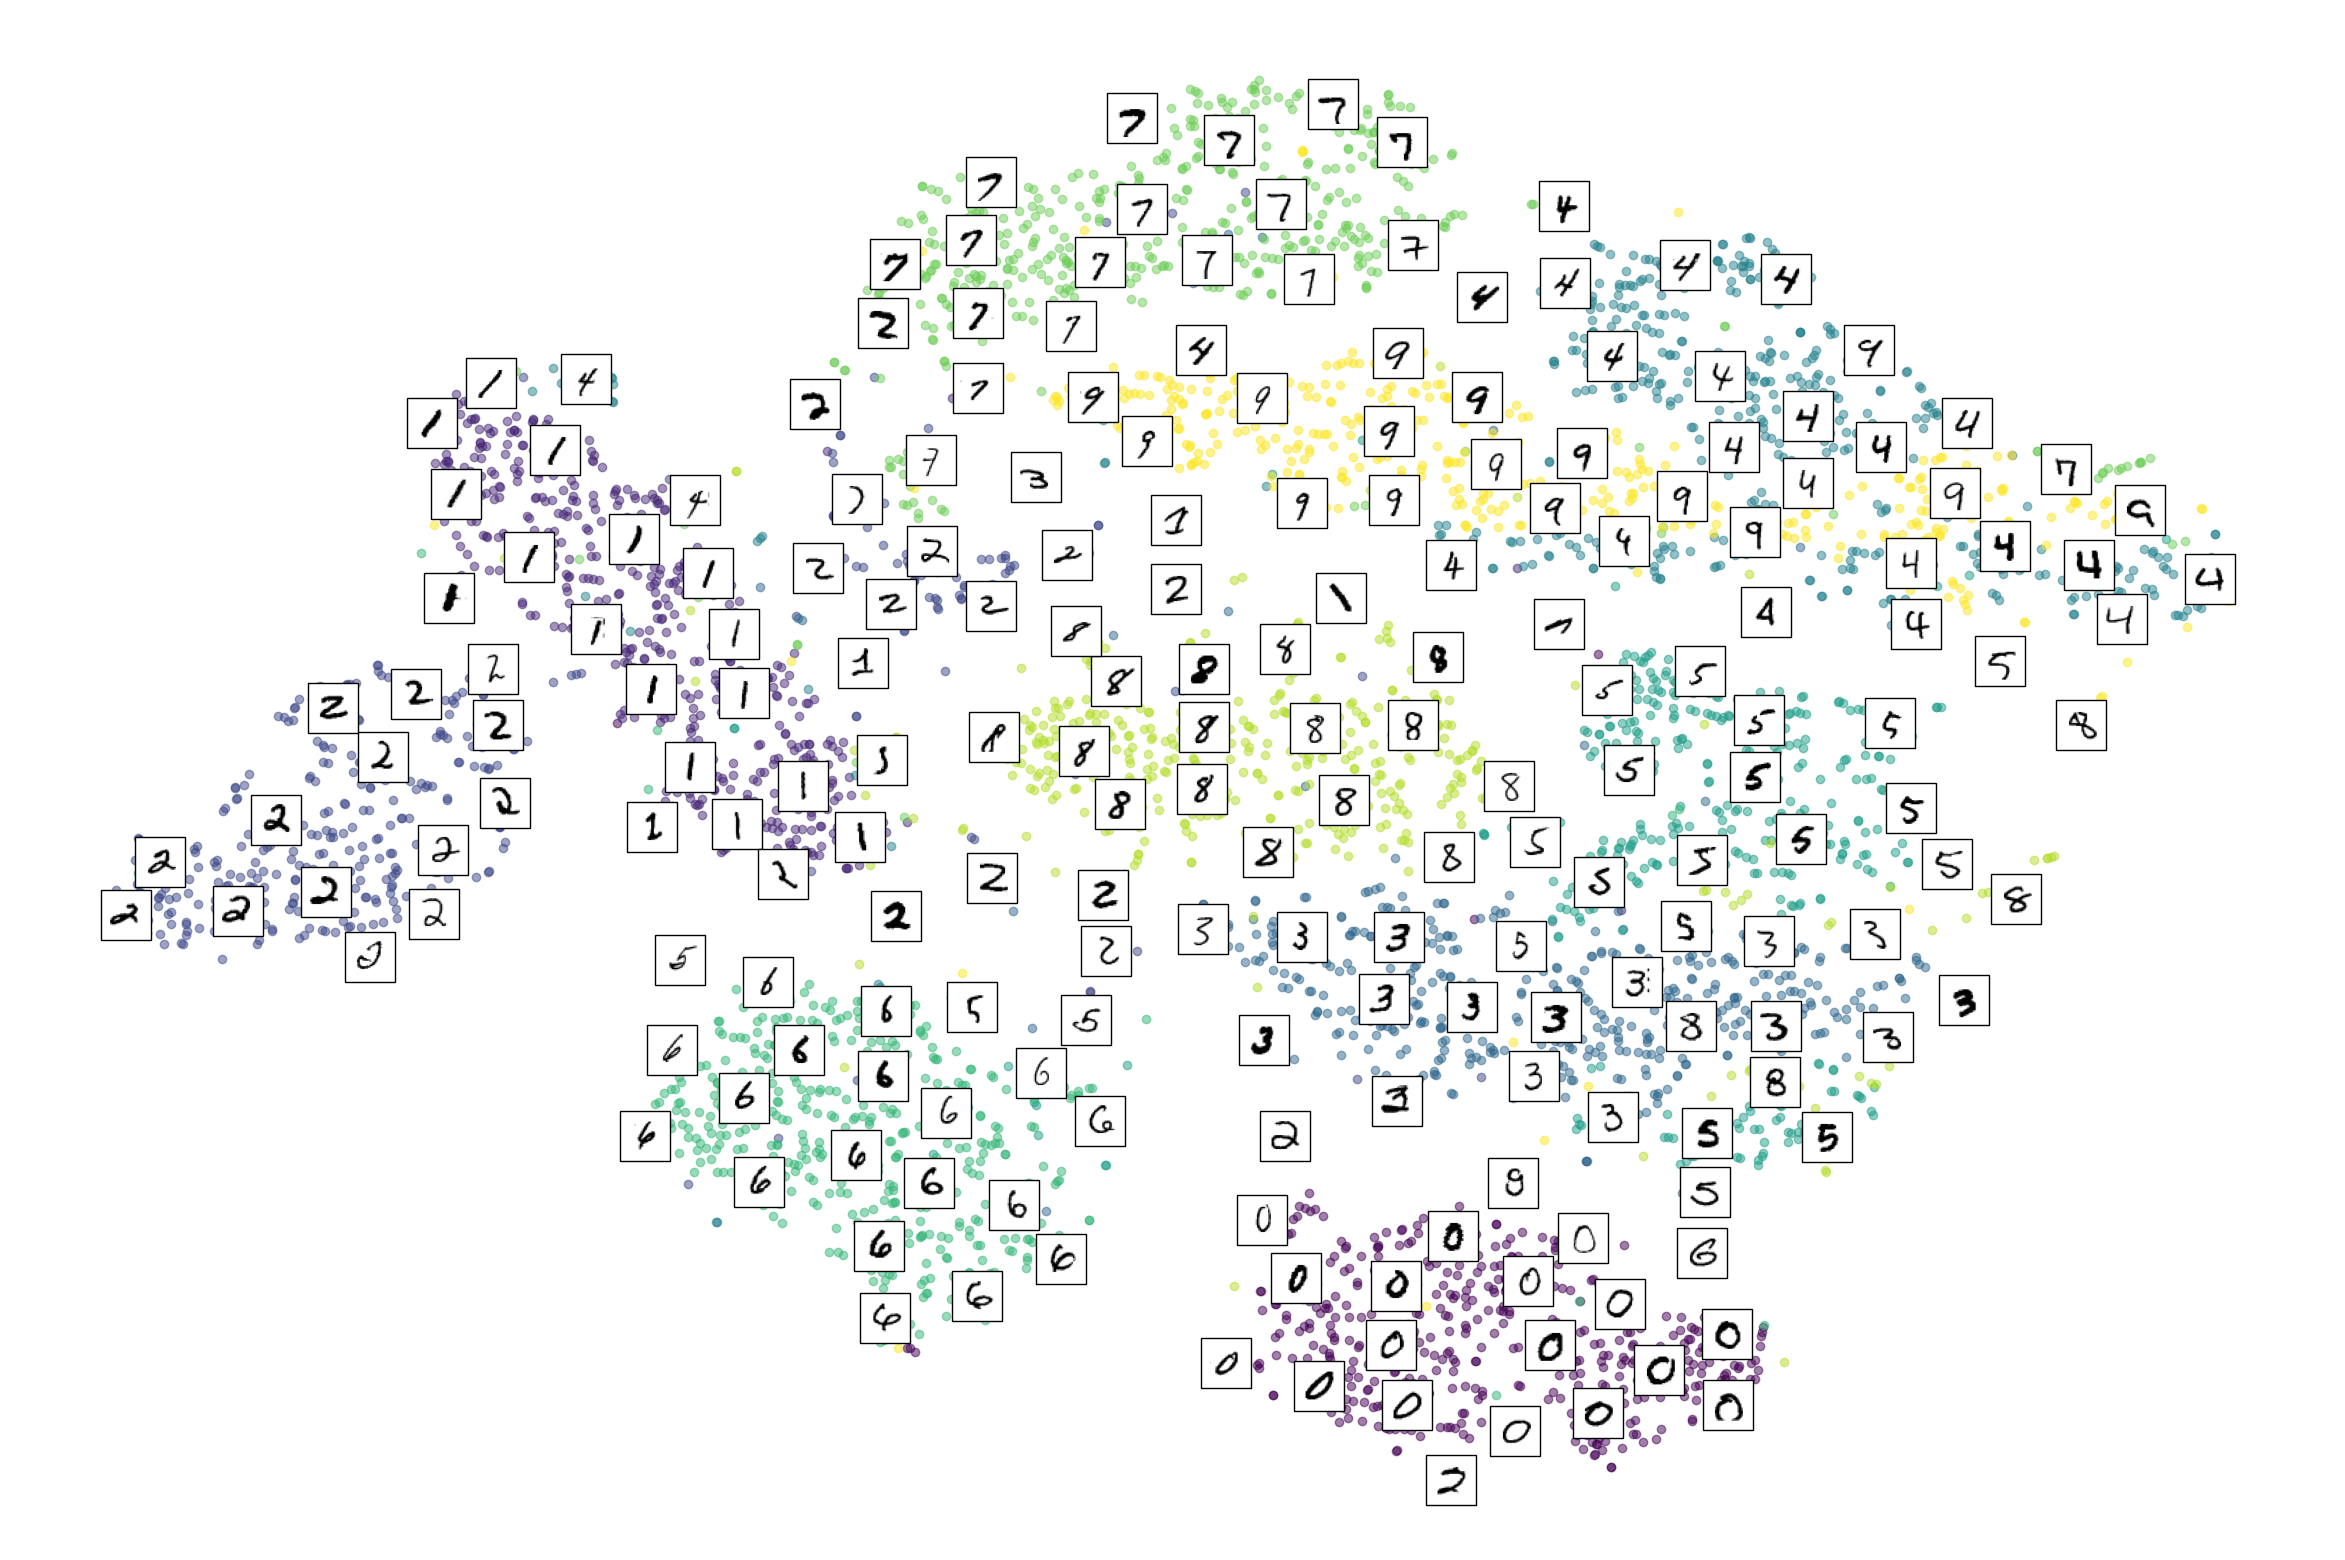

In [187]:
plot_digits(X_reduced,y_sample,images=X_sample,figsize=(30, 20))

In [177]:
# plot_digits(X_subset_reduced,y_subset,images=X_subset)

In [88]:
pca=PCA(n_components=2,random_state=43)
%time X_reduced_pca=pca.fit_transform(X_sample)


CPU times: user 674 ms, sys: 15.4 ms, total: 690 ms
Wall time: 106 ms


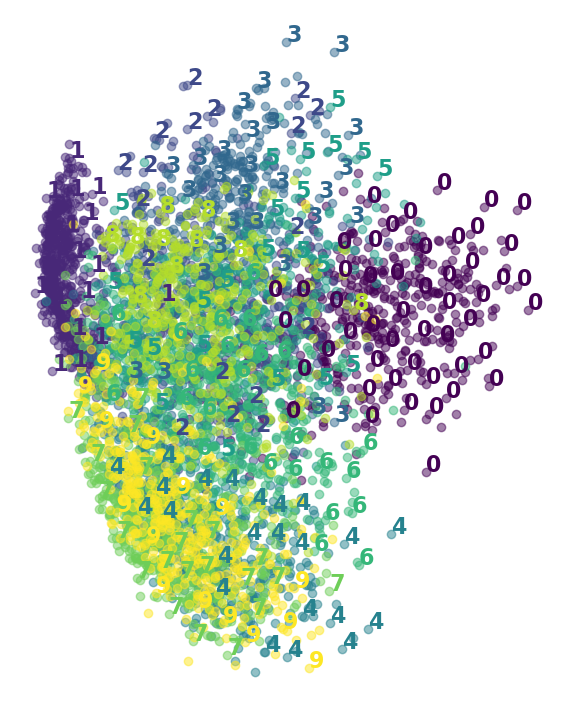

In [199]:
plot_digits(X_reduced_pca,y_sample,figsize=(7, 9))

CPU times: user 13.4 s, sys: 555 ms, total: 14 s
Wall time: 2.07 s


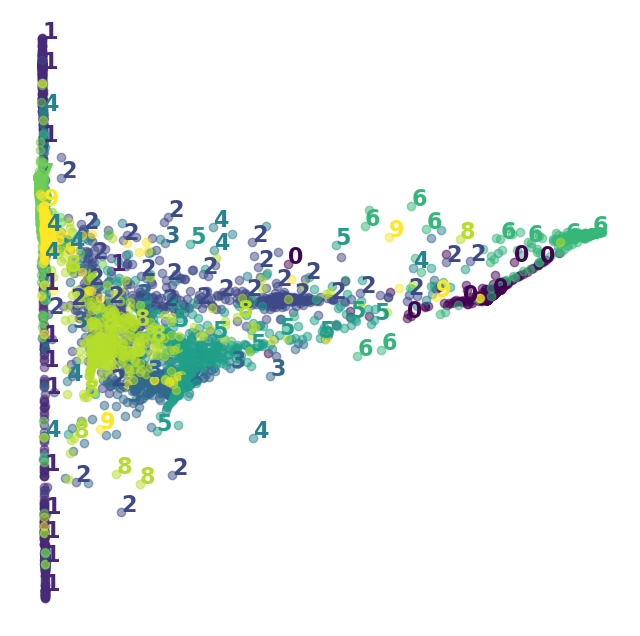

In [203]:
lle=LocallyLinearEmbedding(n_components=2,random_state=42)
%time X_reduced_lle=lle.fit_transform(X_sample)
plot_digits(X_reduced_lle,y_sample,figsize=(8, 8))

In [205]:
pca_tsne=make_pipeline(PCA(n_components=0.95),
                      TSNE(n_components=2,init="random",learning_rate="auto",random_state=42))
%time X_reduced_pca_tsne=pca_tsne.fit_transform(X_sample)
# plot_digits(X_reduced_pca_tsne,y_sample)

CPU times: user 37.6 s, sys: 1.57 s, total: 39.2 s
Wall time: 33.8 s


In [213]:
pca_lle=make_pipeline(PCA(n_components=0.95),
                        LocallyLinearEmbedding(n_components=2,random_state=42))
%time X_reduced_pca_lle=pca_lle.fit_transform(X_sample)
# plot_digits(X_reduced_pca_lle,y_sample)

CPU times: user 14.5 s, sys: 1.17 s, total: 15.7 s
Wall time: 2.05 s


CPU times: user 17min 20s, sys: 27min 19s, total: 44min 39s
Wall time: 6min 12s


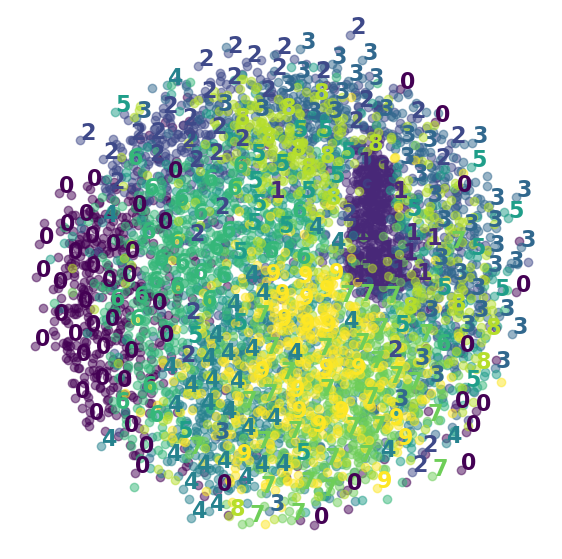

In [215]:
mds=MDS(n_components=2,normalized_stress=False,random_state=42)
%time X_reduced_mds=mds.fit_transform(X_sample)
plot_digits(X_reduced_mds,y_sample,figsize=(7,7))

In [179]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda=LinearDiscriminantAnalysis(n_components=2)
%time X_lda_reduced=lda.fit_transform(X_sample,y_sample)
# plot_digits(X_lda_reduced,y_sample)

CPU times: user 3.85 s, sys: 114 ms, total: 3.96 s
Wall time: 636 ms


**t-SNE won this competition!**